# Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import os
import random

In [2]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 20.0 MB/s eta 0:00:00


In [3]:
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split

# Data

## Data Load

In [41]:
chembl_data = pd.read_csv('/content/drive/MyDrive/DACON/제2회 신약개발 AI 경진대회/open/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/DACON/제2회 신약개발 AI 경진대회/open/test.csv')

In [42]:
num_chembl = len(chembl_data['Assay ChEMBL ID'].unique())
num_smiles = len(chembl_data['Smiles'].unique())

print('Number of Assay ChEMBL IDs', num_chembl)
print('Number of Smiles', num_smiles)

Number of Assay ChEMBL IDs 72
Number of Smiles 1952


## Data Pre-processing

In [43]:
# Function to generate ECFP fingerprint from SMILES
def generate_ecfp(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError("Invalid SMILES string")
    ecfp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
    return ecfp

In [44]:
# smiles to ECFP fingerprint
dataset = chembl_data[['Assay ChEMBL ID', 'IC50_nM', 'Smiles']].copy()
dataset.loc[:, 'ECFP'] = dataset['Smiles'].apply(generate_ecfp)
ecfp_array = np.array(dataset['ECFP'].tolist())

# smiles 열 drop
dataset.drop('Smiles', axis=1, inplace=True)

# assay chembl id 정수 변환
dataset['Assay ChEMBL ID'] = dataset['Assay ChEMBL ID'].str.extract('(\d+)', expand=False).astype(int)

[02:27:48] DEPRECATION WARNING: please use MorganGenerator
[02:27:48] DEPRECATION WARNING: please use MorganGenerator
[02:27:48] DEPRECATION WARNING: please use MorganGenerator
[02:27:48] DEPRECATION WARNING: please use MorganGenerator
[02:27:48] DEPRECATION WARNING: please use MorganGenerator
[02:27:48] DEPRECATION WARNING: please use MorganGenerator
[02:27:48] DEPRECATION WARNING: please use MorganGenerator
[02:27:48] DEPRECATION WARNING: please use MorganGenerator
[02:27:48] DEPRECATION WARNING: please use MorganGenerator
[02:27:48] DEPRECATION WARNING: please use MorganGenerator
[02:27:48] DEPRECATION WARNING: please use MorganGenerator
[02:27:48] DEPRECATION WARNING: please use MorganGenerator
[02:27:48] DEPRECATION WARNING: please use MorganGenerator
[02:27:48] DEPRECATION WARNING: please use MorganGenerator
[02:27:48] DEPRECATION WARNING: please use MorganGenerator
[02:27:48] DEPRECATION WARNING: please use MorganGenerator
[02:27:48] DEPRECATION WARNING: please use MorganGenerat

# K-Means: train data

## Find optimum number of cluster

In [45]:
# 데이터 로드
X = dataset['Assay ChEMBL ID'].values.reshape(-1, 1)
y = dataset['ECFP']

In [46]:
#Find optimum number of cluster
sse = [] #SUM OF SQUARED ERROR
for k in range(1,11):
	km = KMeans(n_clusters=k, random_state=2, n_init=10)
	km.fit(X)
	sse.append(km.inertia_)

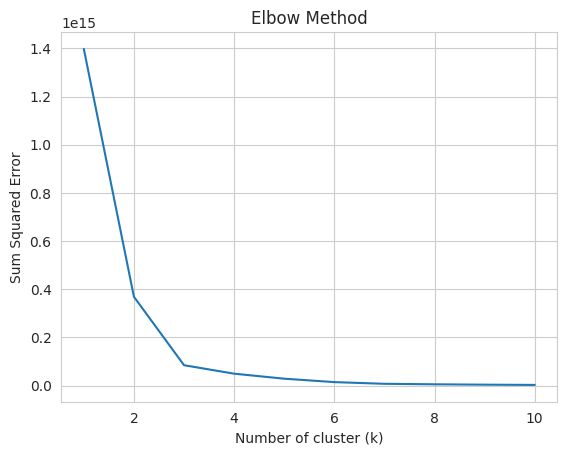

In [47]:
sns.set_style("whitegrid")
g=sns.lineplot(x=range(1,11), y=sse)

g.set(xlabel ="Number of cluster (k)",
	ylabel = "Sum Squared Error",
	title ='Elbow Method')

plt.show()

In [48]:
kmeans = KMeans(n_clusters = 3, random_state = 2)
kmeans.fit(X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3, random_state=2)

## Implement K-Means & Find Cluster Centers

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


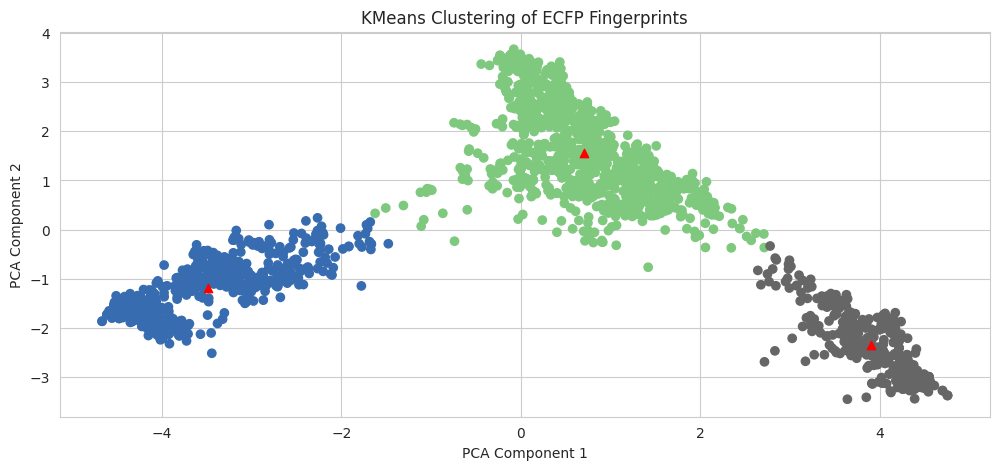

In [49]:
kmeans = KMeans(n_clusters=3, random_state=42)
pred = kmeans.fit_predict(ecfp_array)

pca = PCA(n_components=2)
reduced_ecfp = pca.fit_transform(ecfp_array)

plt.figure(figsize=(12, 5))
plt.scatter(reduced_ecfp[:, 0], reduced_ecfp[:, 1], c=pred, cmap=cm.Accent)
plt.grid(True)
for center in kmeans.cluster_centers_:
    reduced_center = pca.transform([center])
    plt.scatter(reduced_center[0, 0], reduced_center[0, 1], marker='^', c='red')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("KMeans Clustering of ECFP Fingerprints")
plt.show()

In [50]:
print("Cluster Centers:\n", kmeans.cluster_centers_)

Cluster Centers:
 [[ 7.04934542e-03  2.00402820e-01  3.62537764e-02 ... -2.19008839e-17
   8.15709970e-02  1.20845921e-02]
 [ 5.63785130e-18  9.53410982e-01  3.32778702e-03 ... -1.23599048e-17
   2.66222962e-02  3.32778702e-03]
 [-9.54097912e-18  3.91061453e-02  3.35195531e-02 ...  8.37988827e-03
  -1.59594560e-16 -1.90819582e-17]]


# K-Means: center = test data

## Data Pre-processing

In [51]:
# smiles to ECFP fingerprint
dataset2 = test_data[['Smiles']].copy()
dataset2.loc[:, 'ECFP'] = test_data['Smiles'].apply(generate_ecfp)

[02:28:38] DEPRECATION WARNING: please use MorganGenerator
[02:28:38] DEPRECATION WARNING: please use MorganGenerator
[02:28:38] DEPRECATION WARNING: please use MorganGenerator
[02:28:38] DEPRECATION WARNING: please use MorganGenerator
[02:28:38] DEPRECATION WARNING: please use MorganGenerator
[02:28:38] DEPRECATION WARNING: please use MorganGenerator
[02:28:38] DEPRECATION WARNING: please use MorganGenerator
[02:28:38] DEPRECATION WARNING: please use MorganGenerator
[02:28:38] DEPRECATION WARNING: please use MorganGenerator
[02:28:38] DEPRECATION WARNING: please use MorganGenerator
[02:28:38] DEPRECATION WARNING: please use MorganGenerator
[02:28:38] DEPRECATION WARNING: please use MorganGenerator
[02:28:38] DEPRECATION WARNING: please use MorganGenerator
[02:28:38] DEPRECATION WARNING: please use MorganGenerator
[02:28:38] DEPRECATION WARNING: please use MorganGenerator
[02:28:38] DEPRECATION WARNING: please use MorganGenerator
[02:28:38] DEPRECATION WARNING: please use MorganGenerat

## Implement K-Means

In [54]:
train_ecfp_array = np.array(dataset['ECFP'].tolist())
test_ecfp_array = np.array(dataset2['ECFP'].tolist())

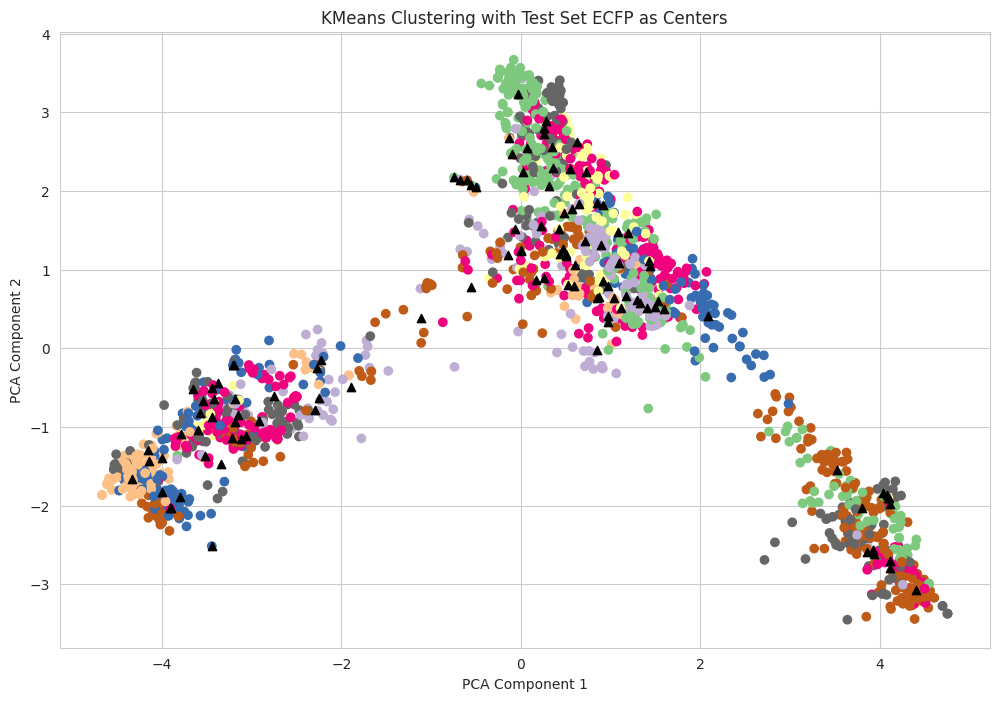

In [56]:
test_centers = test_ecfp_array

kmeans = KMeans(n_clusters=len(test_centers), init=test_centers, n_init=1, random_state=42)
kmeans.fit(train_ecfp_array)
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

pca = PCA(n_components=2)
reduced_X = pca.fit_transform(train_ecfp_array)
reduced_centers = pca.transform(cluster_centers)

plt.figure(figsize=(12, 8))
plt.scatter(reduced_X[:, 0], reduced_X[:, 1], c=labels, cmap=cm.Accent)
plt.scatter(reduced_centers[:, 0], reduced_centers[:, 1], marker='^', c='black')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('KMeans Clustering with Test Set ECFP as Centers')
plt.grid(True)
plt.show()

## test data에 가까운 데이터로 구성된 새로운 데이터 생성

In [66]:
def find_top_n_closest(data, centers, labels, n=5):
    top_n_indices = []
    for i, center in enumerate(centers):
        cluster_data = data[labels == i]
        cluster_indices = np.where(labels == i)[0]
        distances = np.linalg.norm(cluster_data - center, axis=1)
        top_n_idx = distances.argsort()[:n]
        top_n_indices.extend(cluster_indices[top_n_idx])
    return top_n_indices

top_n = 3
top_n_indices = find_top_n_closest(train_ecfp_array, cluster_centers, labels, n=top_n)

selected_train_df = dataset.iloc[top_n_indices]
print(f"Original training data size: {dataset.shape}")
print(f"Selected training data size: {selected_train_df.shape}")

Original training data size: (1952, 3)
Selected training data size: (271, 3)


In [68]:
selected_train_df

,Assay ChEMBL ID,IC50_nM,ECFP
1023,3887963,18.000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1803,3887963,2200.000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1382,3887963,131.000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
0,4361896,0.022,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
2,4345131,0.078,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
...,...,...,...
226,3887118,2.000,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
528,3887118,4.600,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1037,3625600,19.000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1492,3887893,255.000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## Model1: random forest

In [69]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [71]:
df1 = selected_train_df

train_df1, test_df1 = train_test_split(df1, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(list(train_df1['ECFP']), train_df1['IC50_nM'])

test_predictions = model.predict(list(test_df1['ECFP']))

mae = mean_absolute_error(test_df1['IC50_nM'], test_predictions)
r2 = r2_score(test_df1['IC50_nM'], test_predictions)

print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")

test_results = test_df1.copy()
test_results['Predicted_IC50_nM'] = test_predictions
test_results

Mean Absolute Error: 1348.5940031515152
R^2 Score: -0.006618557304255646


,Assay ChEMBL ID,IC50_nM,ECFP,Predicted_IC50_nM
1892,3887963,5000.000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",1470.392600
9,4345131,0.160,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",2.154320
1549,5029479,368.000,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",820.906300
608,3887118,5.600,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",11.199000
359,3887118,3.000,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",4.720000
310,3887118,2.700,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.222400
518,3887118,4.500,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3.530333
695,3887118,7.100,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",10.860000
1671,4427852,730.000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",242.833000
880,3887893,11.800,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",39.407000


- MAE: 모델의 예측이 실제 IC50 값에서 평균적으로 약 1348.59 nM만큼 벗어남
- R2: 음수 값은 모델이 단순 평균보다도 더 못한 성능

- feature 부족
- 모델 개선 필요
- 교차 검증

## Model2: Gradient Boosting

In [73]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [74]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__max_depth': [3, 5, 7]
}

# GridSearchCV를 사용한 하이퍼파라미터 튜닝 및 교차 검증
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(list(train_df1['ECFP']), train_df1['IC50_nM'])

# 최적의 모델로 예측 수행
best_model = grid_search.best_estimator_
test_predictions = best_model.predict(list(test_df1['ECFP']))

mae = mean_absolute_error(test_df1['IC50_nM'], test_predictions)
r2 = r2_score(test_df1['IC50_nM'], test_predictions)

print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")

test_results = test_df1.copy()
test_results['Predicted_IC50_nM'] = test_predictions
test_results

Mean Absolute Error: 1266.6512124817405
R^2 Score: -0.023829078387773928


,Assay ChEMBL ID,IC50_nM,ECFP,Predicted_IC50_nM
1892,3887963,5000.000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",1650.766961
9,4345131,0.160,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",28.903974
1549,5029479,368.000,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",297.693598
608,3887118,5.600,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",4.694160
359,3887118,3.000,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",1.617540
310,3887118,2.700,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2.701260
518,3887118,4.500,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.172715
695,3887118,7.100,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",22.508407
1671,4427852,730.000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",103.170208
880,3887893,11.800,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",36.986107


# K-NN: Select training data

In [82]:
from sklearn.neighbors import NearestNeighbors

# Nearest Neighbors를 사용하여 테스트 데이터에 가장 가까운 학습 데이터를 찾기
nn = NearestNeighbors(n_neighbors=5, metric='jaccard')
nn.fit(train_ecfp_array)
distances, indices = nn.kneighbors(test_ecfp_array)

# 가장 가까운 학습 데이터를 기반으로 새로운 학습 데이터셋 생성
selected_train_indices = np.unique(indices.flatten())
selected_train_df2 = dataset.iloc[selected_train_indices]

# 원래 학습 데이터와 선택된 학습 데이터를 비교하여 크기 확인
print(f"Original training data size: {dataset.shape}")
print(f"Selected training data size: {selected_train_df2.shape}")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/pairwise.py:2182: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Original training data size: (1952, 3)
Selected training data size: (112, 3)


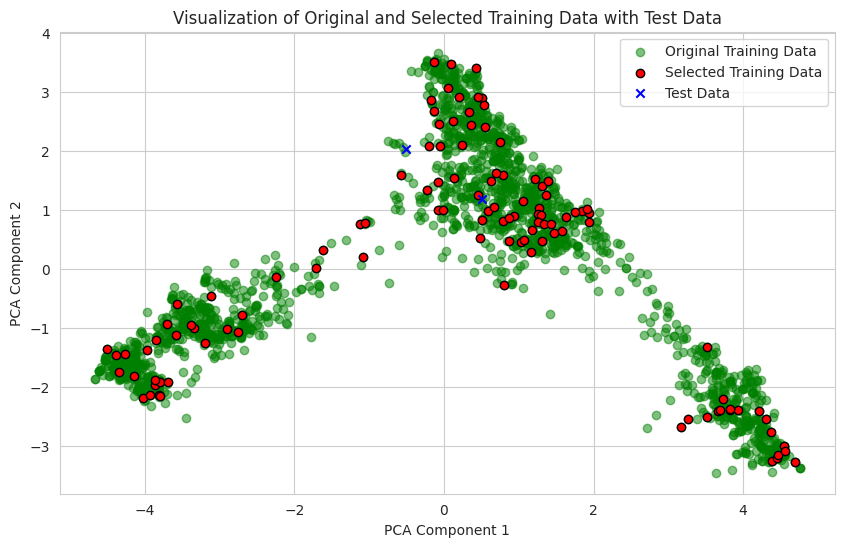

In [85]:
# PCA를 사용하여 2차원으로 축소
pca = PCA(n_components=2)
reduced_X = pca.fit_transform(ecfp_array)

# 원래 학습 데이터와 선택된 학습 데이터를 시각화
plt.figure(figsize=(10, 6))

# 원래 학습 데이터
plt.scatter(reduced_X[2:, 0], reduced_X[2:, 1], c='green', label='Original Training Data', alpha=0.5)

# 선택된 학습 데이터
plt.scatter(reduced_X[selected_train_indices + 2, 0], reduced_X[selected_train_indices + 2, 1], c='red', label='Selected Training Data', edgecolors='black')

# 테스트 데이터
plt.scatter(reduced_X[:2, 0], reduced_X[:2, 1], c='blue', label='Test Data', marker='x')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Visualization of Original and Selected Training Data with Test Data')
plt.legend()
plt.grid(True)
plt.show()

## Model1: random forest

In [78]:
df2 = selected_train_df2

train_df2, test_df2 = train_test_split(df2, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(list(train_df2['ECFP']), train_df2['IC50_nM'])

test_predictions = model.predict(list(test_df2['ECFP']))

mae = mean_absolute_error(test_df2['IC50_nM'], test_predictions)
r2 = r2_score(test_df2['IC50_nM'], test_predictions)

print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")

test_results = test_df2.copy()
test_results['Predicted_IC50_nM'] = test_predictions
test_results

Mean Absolute Error: 126.08230434782611
R^2 Score: 0.09410163480781575


,Assay ChEMBL ID,IC50_nM,ECFP,Predicted_IC50_nM
622,3887118,5.7,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",99.063
1043,921622,19.0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",388.577
62,3887963,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",140.584
793,3887118,8.9,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.737
702,3887118,7.1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",7.125
1110,4047622,25.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",21.489
387,3887118,3.2,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",9.031
154,3887118,1.7,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",22.365
151,3887118,1.7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",51.588
709,4022135,7.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",45.009


## Model2: Gradient Boosting

In [79]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__max_depth': [3, 5, 7]
}

# GridSearchCV를 사용한 하이퍼파라미터 튜닝 및 교차 검증
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(list(train_df2['ECFP']), train_df2['IC50_nM'])

# 최적의 모델로 예측 수행
best_model = grid_search.best_estimator_
test_predictions = best_model.predict(list(test_df2['ECFP']))

mae = mean_absolute_error(test_df2['IC50_nM'], test_predictions)
r2 = r2_score(test_df2['IC50_nM'], test_predictions)

print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")

test_results = test_df2.copy()
test_results['Predicted_IC50_nM'] = test_predictions
test_results

Mean Absolute Error: 115.33291092424776
R^2 Score: -0.21577814175748466


,Assay ChEMBL ID,IC50_nM,ECFP,Predicted_IC50_nM
622,3887118,5.7,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",10.909239
1043,921622,19.0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",525.206108
62,3887963,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",108.828275
793,3887118,8.9,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8.671105
702,3887118,7.1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",10.909239
1110,4047622,25.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",14.094736
387,3887118,3.2,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",4.838798
154,3887118,1.7,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",10.909239
151,3887118,1.7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.339524
709,4022135,7.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",32.785546


# LLM: GPT-4o

In [75]:
!pip install --upgrade openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.4/360.4 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.7 MB/s eta 0:00:00


In [119]:
import openai
from openai import OpenAI
import os
OPENAI_API_KEY = ''
client = OpenAI(api_key=OPENAI_API_KEY)

## GPT API 사용: K-NN

In [131]:
train_df2, test_df2 = train_test_split(df2, test_size=0.2, random_state=42)

random_indices = random.sample(range(train_df2.shape[0]), 30)
random_samples = train_df2.iloc[random_indices]

# 시스템 프롬프트
system_prompt = ""
for idx, (ecfp, assay_id, actual_ic50) in enumerate(zip(random_samples['ECFP'], random_samples['Assay ChEMBL ID'], random_samples['IC50_nM'])):
    system_prompt += f"ECFP가 {ecfp}일 때 Assay ChEMBL ID {assay_id}에 붙는 IC50은 실제값 {actual_ic50} nM\n"

system_prompt += '입력하는 ECFP에 대해서 IC50을 예측하여 답한다. 숫자로만 응답할 것.(예: 0.022, 0.026, 0.099 등)'

In [132]:
def get_gpt_response(prompt, model="gpt-4o"):
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": prompt}
        ],
        max_tokens=150,
        n=1,
        stop=None,
        temperature=0
    )
    return response.choices[0].message.content

In [133]:
# 테스트 데이터 예측
predicted_ic50 = []
actual_ic50 = []

for ecfp in test_df2['ECFP']:
    predicted_ic50.append(get_gpt_response(f"ECFP가 {ecfp}일 때 IC50 예측값(숫자)을 답할 것"))

actual_ic50 = test_df2['IC50_nM'].tolist()

In [134]:
predicted_ic50

['10.0',
 '답: 0.8',
 '0.8',
 '알 수 없음',
 '0.001',
 '0.8',
 '3.0',
 '1.9',
 '0.8',
 '1.5',
 '0.008',
 '0.8',
 '0.8',
 '220.0',
 '0.8',
 '0.8',
 '0.8',
 '0.8',
 '220.0',
 '0.008',
 '0.008',
 '1.9',
 '0.8']

In [135]:
processed_ic50 = []

for response in predicted_ic50:
    try:
        # 문자열에서 숫자만 추출
        number = float(response)
        processed_ic50.append(number)
    except ValueError:
        # '알 수 없음' 등
        processed_ic50.append(0.0)

processed_ic50

[10.0,
 0.0,
 0.8,
 0.0,
 0.001,
 0.8,
 3.0,
 1.9,
 0.8,
 1.5,
 0.008,
 0.8,
 0.8,
 220.0,
 0.8,
 0.8,
 0.8,
 0.8,
 220.0,
 0.008,
 0.008,
 1.9,
 0.8]

In [138]:
mae = mean_absolute_error(actual_ic50, processed_ic50)
r2 = r2_score(actual_ic50, processed_ic50)

print(f"Mean Absolute Error: {mae}")
print(f"R2 Score: {r2}")

Mean Absolute Error: 62.91630434782609
R2 Score: 0.312733176311938


## GPT API 사용: K-Means

In [141]:
train_df1, test_df1 = train_test_split(df1, test_size=0.2, random_state=42)

random_indices = random.sample(range(train_df1.shape[0]), 30)
random_samples = train_df1.iloc[random_indices]

# 시스템 프롬프트
system_prompt_m = ""
for idx, (ecfp, assay_id, actual_ic50) in enumerate(zip(random_samples['ECFP'], random_samples['Assay ChEMBL ID'], random_samples['IC50_nM'])):
    system_prompt_m += f"ECFP가 {ecfp}일 때 Assay ChEMBL ID {assay_id}에 붙는 IC50은 실제값 {actual_ic50} nM\n"

system_prompt_m += '입력하는 ECFP에 대해서 IC50을 예측하여 답한다. 숫자로만 응답할 것.(예: 0.022, 0.026, 0.099 등)'

In [142]:
def get_gpt_response(prompt, model="gpt-4o"):
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": system_prompt_m},
            {"role": "user", "content": prompt}
        ],
        max_tokens=150,
        n=1,
        stop=None,
        temperature=0
    )
    return response.choices[0].message.content

In [143]:
# 테스트 데이터 예측
predicted_ic50 = []
actual_ic50 = []

for ecfp in test_df1['ECFP']:
    predicted_ic50.append(get_gpt_response(f"ECFP가 {ecfp}일 때 IC50 예측값(숫자)을 답할 것"))

actual_ic50 = test_df1['IC50_nM'].tolist()

In [144]:
predicted_ic50

['2.3',
 '1.8',
 '1.8',
 '1.6',
 '1.8',
 '2.0',
 '1.6',
 '2.0',
 '1.8',
 '2.0',
 '1.6',
 '1.6',
 '2.3',
 '2.3',
 '1.6',
 '1.6',
 '1.6',
 '0.29',
 '0.29',
 '0.29',
 '1.8',
 '1.6',
 '1.6',
 '1.8',
 '35.0',
 '1.8',
 '1.6',
 '35.0',
 '1.8',
 '0.29',
 '1.8',
 '1.8',
 '0.022',
 '1.8',
 '1.3',
 '2.3',
 '1.8',
 '1.3',
 '1.8',
 '0.29',
 '2.0',
 '1.6',
 '1.7',
 '1.8',
 '2.3',
 '1.8',
 '1.8',
 '1.6',
 '1.6',
 '1.8',
 '1.8',
 '0.022',
 '1.6',
 '1.8',
 '1.8']

In [145]:
processed_ic50 = []

for response in predicted_ic50:
    try:
        # 문자열에서 숫자만 추출
        number = float(response)
        processed_ic50.append(number)
    except ValueError:
        # '알 수 없음' 등
        processed_ic50.append(0.0)

processed_ic50

[2.3,
 1.8,
 1.8,
 1.6,
 1.8,
 2.0,
 1.6,
 2.0,
 1.8,
 2.0,
 1.6,
 1.6,
 2.3,
 2.3,
 1.6,
 1.6,
 1.6,
 0.29,
 0.29,
 0.29,
 1.8,
 1.6,
 1.6,
 1.8,
 35.0,
 1.8,
 1.6,
 35.0,
 1.8,
 0.29,
 1.8,
 1.8,
 0.022,
 1.8,
 1.3,
 2.3,
 1.8,
 1.3,
 1.8,
 0.29,
 2.0,
 1.6,
 1.7,
 1.8,
 2.3,
 1.8,
 1.8,
 1.6,
 1.6,
 1.8,
 1.8,
 0.022,
 1.6,
 1.8,
 1.8]

In [146]:
mae = mean_absolute_error(actual_ic50, processed_ic50)
r2 = r2_score(actual_ic50, processed_ic50)

print(f"Mean Absolute Error: {mae}")
print(f"R2 Score: {r2}")

Mean Absolute Error: 1231.1717636363633
R2 Score: -0.04637347028234573
